In [1]:
import pandas as pd 
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from pathlib import Path

# settings to display all columns
pd.set_option("display.max_columns", None)

## Load data

In [2]:
# Sales data: Training Set (1-1913) + Validation Set (1914 - 1941)
sales = pd.read_csv('./sales_train_evaluation.csv')
sales.name = 'sales'
print(len(sales))
sales.head()

30490


id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     2     0     0     0     2     0     1     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     2     0     1     0     0     1     1     1     0     2     3   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     1     0     0     0     0     0     1     0     0     1     1     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     1     0     0     1     2     3     0     2     0     0     2   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   


In [3]:
# Calendar
calendar = pd.read_csv('./calendar.csv')
calendar.name = 'calendar'
print(len(calendar))
calendar.head()

1969


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [4]:
# Pricing
prices = pd.read_csv('./sell_prices.csv')
prices.name = 'prices'
print(len(prices))
prices.head()

6841121


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [5]:
# adding records to match calendar days
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)
print(len(sales))
sales.head()

30490


id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     2     0     0     0     2     0     1     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     2     0     1     0     0     1     1     1     0     2     3   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     1     0     0     0     0     0     1     0     0     1     1     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     1     0     0     1     2     3     0     2     0     0     2   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   


### Dowcasting to reduce memory

In [6]:
# Dowcasting the memory usage
# For int varibles check in which category it fits: int8, int16, int32 or int64
# same for float varibles. float16, float32 or float64
# for object, if is a date, changes to date format, else change to category
# reference Source: https://www.kaggle.com/anshuls235/time-series-forecasting-eda-fe-modelling

def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        # Integer
        if 'int' in str(t):
            # Check if minimum and maximum are in the limit of int8
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            # Check if minimum and maximum are in the limit of int16
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            # Check if minimum and maximum are in the limit of int32
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            # Choose int64
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        # Float
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        # Object
        elif t == object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

# # Apply downcasting
sales = downcast(sales)
prices = downcast(prices)
calendar = downcast(calendar)

---
## Feature Engineering

Time Series data must be re-framed as a supervised learning dataset before we can start using machine learning algorithms:

* There is no concept of input and output features in time series.
* Instead, we must choose the variable to be predicted and use feature engineering to construct all of the inputs that will be used to make predictions for future time steps.

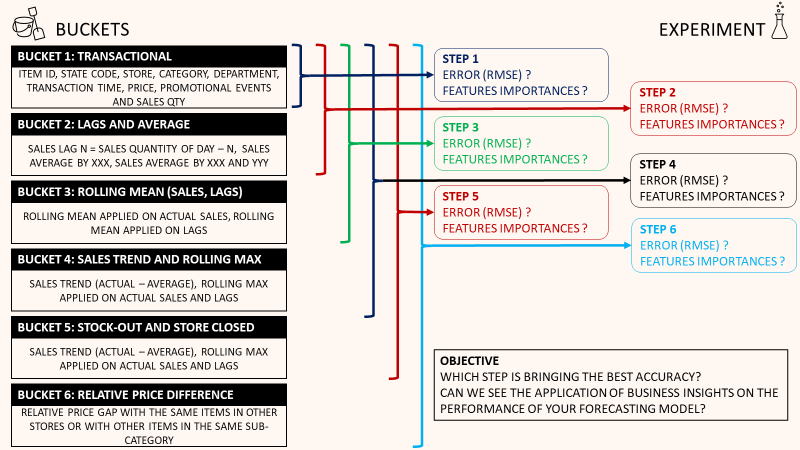

### Aditional Features: Pricing
* Relative difference between the current price of an item and its historical average price, to highlight promotional offers’ impact.
* Price relative difference with the same item sold in other stores, to understand whether or not the store has an attractive price.
* Price relative difference with other items sold in the same store and same product category, to capture some cannibalization effects.

In [7]:
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


In [8]:
# Calculate the average price for all stores
df_mean_store = pd.DataFrame(prices.groupby(['item_id','wm_yr_wk'])['sell_price'].mean())
df_mean_store.columns = ['item_sells_price_avg']
df_mean_store.reset_index(inplace=True)
df_mean_store.head(10)

,item_id,wm_yr_wk,item_sells_price_avg
0,FOODS_1_001,11101,2.0
1,FOODS_1_001,11102,2.0
2,FOODS_1_001,11103,2.0
3,FOODS_1_001,11104,2.0
4,FOODS_1_001,11105,2.0
5,FOODS_1_001,11106,2.0
6,FOODS_1_001,11107,2.0
7,FOODS_1_001,11108,2.0
8,FOODS_1_001,11109,2.0
9,FOODS_1_001,11110,2.0


In [9]:
# Combine with old prices dataframe
prices_new = pd.merge(prices,df_mean_store, on = ['item_id','wm_yr_wk'], how='left',suffixes=('','_y'))
prices_new.drop(prices_new.filter(regex='_y$').columns.to_list(),axis=1,inplace=True)
prices_new.head()

,store_id,item_id,wm_yr_wk,sell_price,item_sells_price_avg
0,CA_1,HOBBIES_1_001,11325,9.578125,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125,9.050000
2,CA_1,HOBBIES_1_001,11327,8.257812,8.777778
3,CA_1,HOBBIES_1_001,11328,8.257812,8.461719
4,CA_1,HOBBIES_1_001,11329,8.257812,8.461719


In [10]:
# Price difference with same items in other stores
prices_new['delta_price_all_rel'] = (prices_new['sell_price'] - prices_new['item_sells_price_avg'])/prices_new['item_sells_price_avg']
prices_new.head()

,store_id,item_id,wm_yr_wk,sell_price,item_sells_price_avg,delta_price_all_rel
0,CA_1,HOBBIES_1_001,11325,9.578125,9.578125,0.000000
1,CA_1,HOBBIES_1_001,11326,9.578125,9.050000,0.058356
2,CA_1,HOBBIES_1_001,11327,8.257812,8.777778,-0.059237
3,CA_1,HOBBIES_1_001,11328,8.257812,8.461719,-0.024097
4,CA_1,HOBBIES_1_001,11329,8.257812,8.461719,-0.024097


In [11]:
# Price difference with last week
prices_new['item_store'] = prices_new['item_id'].astype(str) + "_" + prices_new['store_id'].astype(str)
prices_new['item_store_change'] = prices_new['item_store'].shift() != prices_new['item_store']
prices_new['delta_price_weekn-1'] = (prices_new['sell_price'] - prices_new['sell_price'].shift(1)).fillna(0)/prices_new['sell_price'].shift(1)
prices_new['delta_price_weekn-1'] = prices_new['delta_price_weekn-1'].fillna(0) * (prices_new['item_store_change']==0)
prices_new.head()

,store_id,item_id,wm_yr_wk,sell_price,item_sells_price_avg,delta_price_all_rel,item_store,item_store_change,delta_price_weekn-1
0,CA_1,HOBBIES_1_001,11325,9.578125,9.578125,0.000000,HOBBIES_1_001_CA_1,True,0.000000
1,CA_1,HOBBIES_1_001,11326,9.578125,9.050000,0.058356,HOBBIES_1_001_CA_1,False,0.000000
2,CA_1,HOBBIES_1_001,11327,8.257812,8.777778,-0.059237,HOBBIES_1_001_CA_1,False,-0.137817
3,CA_1,HOBBIES_1_001,11328,8.257812,8.461719,-0.024097,HOBBIES_1_001_CA_1,False,0.000000
4,CA_1,HOBBIES_1_001,11329,8.257812,8.461719,-0.024097,HOBBIES_1_001_CA_1,False,0.000000


In [12]:
# Average price of the department by store
prices_new['dept_id'] = prices_new.item_id.str[:-4]
df_mean_cat = pd.DataFrame(prices_new.groupby(['dept_id', 'store_id', 'wm_yr_wk'])['sell_price'].mean())
df_mean_cat.columns = ['dept_sells_price_avg']
df_mean_cat.reset_index(inplace = True)
df_mean_cat.head()

,dept_id,store_id,wm_yr_wk,dept_sells_price_avg
0,FOODS_1,CA_1,11101,2.988934
1,FOODS_1,CA_1,11102,3.016460
2,FOODS_1,CA_1,11103,2.999285
3,FOODS_1,CA_1,11104,2.976977
4,FOODS_1,CA_1,11105,2.968331


In [13]:
# Combine with price dataset
prices_new = pd.merge(prices_new, df_mean_cat, on=['dept_id', 'store_id', 'wm_yr_wk'], how='left', suffixes=('', '_y'))
prices_new.drop(prices_new.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
prices_new.head()

,store_id,item_id,wm_yr_wk,sell_price,item_sells_price_avg,delta_price_all_rel,item_store,item_store_change,delta_price_weekn-1,dept_id,dept_sells_price_avg
0,CA_1,HOBBIES_1_001,11325,9.578125,9.578125,0.000000,HOBBIES_1_001_CA_1,True,0.000000,HOBBIES_1,6.099359
1,CA_1,HOBBIES_1_001,11326,9.578125,9.050000,0.058356,HOBBIES_1_001_CA_1,False,0.000000,HOBBIES_1,6.252128
2,CA_1,HOBBIES_1_001,11327,8.257812,8.777778,-0.059237,HOBBIES_1_001_CA_1,False,-0.137817,HOBBIES_1,6.235187
3,CA_1,HOBBIES_1_001,11328,8.257812,8.461719,-0.024097,HOBBIES_1_001_CA_1,False,0.000000,HOBBIES_1,6.234968
4,CA_1,HOBBIES_1_001,11329,8.257812,8.461719,-0.024097,HOBBIES_1_001_CA_1,False,0.000000,HOBBIES_1,6.234968


In [14]:
# Cannibalisation: compare this item price with average of the department (category)
prices_new['delta_price_cat_rel'] = (prices_new['sell_price'] -  prices_new['dept_sells_price_avg'])/prices_new['dept_sells_price_avg']
prices_new.head()

,store_id,item_id,wm_yr_wk,sell_price,item_sells_price_avg,delta_price_all_rel,item_store,item_store_change,delta_price_weekn-1,dept_id,dept_sells_price_avg,delta_price_cat_rel
0,CA_1,HOBBIES_1_001,11325,9.578125,9.578125,0.000000,HOBBIES_1_001_CA_1,True,0.000000,HOBBIES_1,6.099359,0.570350
1,CA_1,HOBBIES_1_001,11326,9.578125,9.050000,0.058356,HOBBIES_1_001_CA_1,False,0.000000,HOBBIES_1,6.252128,0.531978
2,CA_1,HOBBIES_1_001,11327,8.257812,8.777778,-0.059237,HOBBIES_1_001_CA_1,False,-0.137817,HOBBIES_1,6.235187,0.324389
3,CA_1,HOBBIES_1_001,11328,8.257812,8.461719,-0.024097,HOBBIES_1_001_CA_1,False,0.000000,HOBBIES_1,6.234968,0.324435
4,CA_1,HOBBIES_1_001,11329,8.257812,8.461719,-0.024097,HOBBIES_1_001_CA_1,False,0.000000,HOBBIES_1,6.234968,0.324435


In [15]:
# Drop columns
prices_new.drop(['item_sells_price_avg', 'item_store_change', 'item_store_change', 'dept_id', 'item_store','dept_sells_price_avg'], axis = 1, inplace = True)

In [16]:
prices_new

,store_id,item_id,wm_yr_wk,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel
0,CA_1,HOBBIES_1_001,11325,9.578125,0.000000,0.000000,0.570350
1,CA_1,HOBBIES_1_001,11326,9.578125,0.058356,0.000000,0.531978
2,CA_1,HOBBIES_1_001,11327,8.257812,-0.059237,-0.137817,0.324389
3,CA_1,HOBBIES_1_001,11328,8.257812,-0.024097,0.000000,0.324435
4,CA_1,HOBBIES_1_001,11329,8.257812,-0.024097,0.000000,0.324435
...,...,...,...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.000000,0.000000,0.000000,-0.656476
6841117,WI_3,FOODS_3_827,11618,1.000000,0.000000,0.000000,-0.656426
6841118,WI_3,FOODS_3_827,11619,1.000000,0.000000,0.000000,-0.656538
6841119,WI_3,FOODS_3_827,11620,1.000000,0.000000,0.000000,-0.656621


### Melt Data and reconstitute sales records

#### Melt

In [17]:
sales.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     2     0     0     0     2     0     1     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     2     0     1     0     0     1     1     1     0     2     3   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     1     0     0     0     0     0     1     0     0     1     1     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     1     0     0     1     2     3     0     2     0     0     2   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   


In [18]:
df = pd.melt(sales,id_vars=['id','item_id','dept_id','cat_id','store_id','state_id'],var_name='d',value_name='sold').dropna()
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [19]:
df.shape

(60034810, 8)

In [20]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [21]:
prices_new.head()

,store_id,item_id,wm_yr_wk,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel
0,CA_1,HOBBIES_1_001,11325,9.578125,0.000000,0.000000,0.570350
1,CA_1,HOBBIES_1_001,11326,9.578125,0.058356,0.000000,0.531978
2,CA_1,HOBBIES_1_001,11327,8.257812,-0.059237,-0.137817,0.324389
3,CA_1,HOBBIES_1_001,11328,8.257812,-0.024097,0.000000,0.324435
4,CA_1,HOBBIES_1_001,11329,8.257812,-0.024097,0.000000,0.324435


In [22]:
prices_new = prices_new[prices_new['store_id'] == 'CA_1']

In [23]:
df = df[df['store_id'] == 'CA_1']

In [24]:
df.shape

(6003481, 8)

In [25]:
del sales
del prices

In [26]:
del df_mean_cat
del df_mean_store

In [27]:
del col
del d

#### Combine data

In [28]:
# Combine with calendar
df = pd.merge(df, calendar, on='d', how='left')

In [29]:
del calendar

In [30]:
# Combine with price
df = pd.merge(df, prices_new, on=['store_id','item_id','wm_yr_wk'], how='left') 

In [31]:
del prices_new

In [32]:
print(len(df))
df.head()

6003481


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN


#### Label enconding

In [33]:
# Change all categorical variables to category
df.id = df.id.astype("category")
df.item_id = df.item_id.astype("category")
df.dept_id = df.dept_id.astype("category")
df.cat_id = df.cat_id.astype("category")
df.store_id = df.store_id.astype("category")
df.state_id = df.state_id.astype("category")

# store the category variables along with ther codes
d_id = dict(zip(df.id.cat.codes,df.id))
d_item_id = dict(zip(df.item_id.cat.codes,df.item_id))
d_dept_id = dict(zip(df.dept_id.cat.codes,df.dept_id))
d_cat_id = dict(zip(df.cat_id.cat.codes,df.cat_id))
d_store_id = dict(zip(df.store_id.cat.codes,df.store_id))
d_state_id = dict(zip(df.state_id.cat.codes,df.state_id))


# Save to Dataframe
LIST_SAVE = [d_id, d_item_id, d_dept_id, d_cat_id, d_store_id, d_state_id]
LIST_NAME = ['d_id', 'd_item_id', 'd_dept_id', 'd_cat_id', 'd_store_id', 'd_state_id']
for list_save, list_name in zip(LIST_SAVE, LIST_NAME):
    pickle.dump(list_save, open('{}.p'.format(list_name), "wb"))

# del unnecessary variables to save memory
del d_id
del d_item_id
del d_dept_id
del d_cat_id
del d_store_id
del d_state_id
del LIST_NAME
del LIST_SAVE
del list_name
del list_save

In [34]:
# mapping with categories code

# remove d_ and transform to int
df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)


cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()

In [35]:
# transform categorical data to codes
for i, type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes

# Drop Dates
df.drop('date',axis=1,inplace=True)
print(df.shape)
df.head()

(6003481, 24)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel
0,14370,1437,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN
1,14380,1438,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN
2,14390,1439,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN
3,14400,1440,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN
4,14410,1441,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN


In [36]:
del cols
del types
del type
del i

#### Lag features

Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems.
* Introduce lags to the the target variable sold.
* The maximum lag I have introduced is 36 days.
* It's purely upto you how many lags you want to introduce.

In [37]:
lags = [1, 2, 3, 7, 14, 28]
for lag in lags:
    df['sold_lag_'+str(lag)] = df.groupby(
        ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False
    )['sold'].shift(lag).astype(np.float16)

df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_7,sold_lag_14,sold_lag_28
0,14370,1437,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14380,1438,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14390,1439,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14400,1440,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14410,1441,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Mean encoding

From a mathematical point of view, mean encoding represents a probability of your target variable, conditional on each value of the feature. In a way, it embodies the target variable in its encoded value.

* item
* state
* store
* category
* department
* category & department
* store & item
* category & item
* department & item
* state & store
* state, store and category
* store, category and department

In [38]:
# Total Average sales by: item, state, store, cat and dept

df['item_sold_avg'] = df.groupby('item_id')['sold'].transform('mean').astype(np.float16)
df['dept_sold_avg'] = df.groupby('dept_id')['sold'].transform('mean').astype(np.float16)
df['cat_sold_avg'] = df.groupby('cat_id')['sold'].transform('mean').astype(np.float16)
df['store_sold_avg'] = df.groupby('store_id')['sold'].transform('mean').astype(np.float16)
df['state_sold_avg'] = df.groupby('state_id')['sold'].transform('mean').astype(np.float16)

In [39]:
# Sales average by combinations of category variables
df['cat_dept_sold_avg'] = df.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
df['store_item_sold_avg'] = df.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['cat_item_sold_avg'] = df.groupby(['cat_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['dept_item_sold_avg'] = df.groupby(['dept_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_sold_avg'] = df.groupby(['state_id','store_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_cat_sold_avg'] = df.groupby(['state_id','store_id','cat_id'])['sold'].transform('mean').astype(np.float16)
df['store_cat_dept_sold_avg'] = df.groupby(['store_id','cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)

In [40]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_7,sold_lag_14,sold_lag_28,item_sold_avg,dept_sold_avg,cat_sold_avg,store_sold_avg,state_sold_avg,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg
0,14370,1437,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.321533,1.020508,0.801758,1.304688,1.304688,1.020508,0.321533,0.321533,0.321533,1.304688,0.801758,1.020508
1,14380,1438,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.253906,1.020508,0.801758,1.304688,1.304688,1.020508,0.253906,0.253906,0.253906,1.304688,0.801758,1.020508
2,14390,1439,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.156982,1.020508,0.801758,1.304688,1.304688,1.020508,0.156982,0.156982,0.156982,1.304688,0.801758,1.020508
3,14400,1440,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.694336,1.020508,0.801758,1.304688,1.304688,1.020508,1.694336,1.694336,1.694336,1.304688,0.801758,1.020508
4,14410,1441,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.958984,1.020508,0.801758,1.304688,1.304688,1.020508,0.958984,0.958984,0.958984,1.304688,0.801758,1.020508


#### Rolling averages on sales

In [41]:
# Rolling mean for 3, 7, 14, 21, 28 days
for days in [3,7,14,21,28]:
    df['rolling_mean_{}'.format(days)] = df.groupby(
        ['id','item_id','dept_id','cat_id','store_id','state_id']        
    )['sold'].transform(
        lambda x: x.rolling(window = days).mean()
    ).astype(np.float16)

In [42]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_7,sold_lag_14,sold_lag_28,item_sold_avg,dept_sold_avg,cat_sold_avg,store_sold_avg,state_sold_avg,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_mean_3,rolling_mean_7,rolling_mean_14,rolling_mean_21,rolling_mean_28
0,14370,1437,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.321533,1.020508,0.801758,1.304688,1.304688,1.020508,0.321533,0.321533,0.321533,1.304688,0.801758,1.020508,NaN,NaN,NaN,NaN,NaN
1,14380,1438,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.253906,1.020508,0.801758,1.304688,1.304688,1.020508,0.253906,0.253906,0.253906,1.304688,0.801758,1.020508,NaN,NaN,NaN,NaN,NaN
2,14390,1439,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.156982,1.020508,0.801758,1.304688,1.304688,1.020508,0.156982,0.156982,0.156982,1.304688,0.801758,1.020508,NaN,NaN,NaN,NaN,NaN
3,14400,1440,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.694336,1.020508,0.801758,1.304688,1.304688,1.020508,1.694336,1.694336,1.694336,1.304688,0.801758,1.020508,NaN,NaN,NaN,NaN,NaN
4,14410,1441,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.958984,1.020508,0.801758,1.304688,1.304688,1.020508,0.958984,0.958984,0.958984,1.304688,0.801758,1.020508,NaN,NaN,NaN,NaN,NaN


#### Rolling Average (Window) on actual lag

*  rmean_7_7: rolling mean sales of a window size of 7 over column lag_7
*  rmean_7_28: rolling mean sales of a window size of 7 over column lag_28
*  rmean_28_7: rolling mean sales of a window size of 28 over column lag_7
*  rmean_28_28: rolling mean sales of a window size of 28 over column lag_28

In [43]:
# Rolling Average on actual lag
for window, lag in zip([7, 7, 28, 28], [7, 28, 7, 28]):
    df['rolling_lag_{}_win_{}'.format(window, lag)] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold_lag_{}'.format(lag)].transform(
    lambda x: x.rolling(window=window).mean()).astype(np.float16)

In [44]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_7,sold_lag_14,sold_lag_28,item_sold_avg,dept_sold_avg,cat_sold_avg,store_sold_avg,state_sold_avg,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_mean_3,rolling_mean_7,rolling_mean_14,rolling_mean_21,rolling_mean_28,rolling_lag_7_win_7,rolling_lag_7_win_28,rolling_lag_28_win_7,rolling_lag_28_win_28
0,14370,1437,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.321533,1.020508,0.801758,1.304688,1.304688,1.020508,0.321533,0.321533,0.321533,1.304688,0.801758,1.020508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14380,1438,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.253906,1.020508,0.801758,1.304688,1.304688,1.020508,0.253906,0.253906,0.253906,1.304688,0.801758,1.020508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14390,1439,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.156982,1.020508,0.801758,1.304688,1.304688,1.020508,0.156982,0.156982,0.156982,1.304688,0.801758,1.020508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14400,1440,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.694336,1.020508,0.801758,1.304688,1.304688,1.020508,1.694336,1.694336,1.694336,1.304688,0.801758,1.020508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14410,1441,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.958984,1.020508,0.801758,1.304688,1.304688,1.020508,0.958984,0.958984,0.958984,1.304688,0.801758,1.020508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Rolling Max (Window): Last n days

In [45]:
df['rolling_sold_max'] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(
    lambda x: x.rolling(window=7).max()).astype(np.float16)

# Average for the last n days
for days in [1, 2, 7, 14, 21, 28]:
    df['rolling_sold_max_{}'.format(days)] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(
    lambda x: x.rolling(window=days).max()).astype(np.float16)

df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_7,sold_lag_14,sold_lag_28,item_sold_avg,dept_sold_avg,cat_sold_avg,store_sold_avg,state_sold_avg,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_mean_3,rolling_mean_7,rolling_mean_14,rolling_mean_21,rolling_mean_28,rolling_lag_7_win_7,rolling_lag_7_win_28,rolling_lag_28_win_7,rolling_lag_28_win_28,rolling_sold_max,rolling_sold_max_1,rolling_sold_max_2,rolling_sold_max_7,rolling_sold_max_14,rolling_sold_max_21,rolling_sold_max_28
0,14370,1437,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.321533,1.020508,0.801758,1.304688,1.304688,1.020508,0.321533,0.321533,0.321533,1.304688,0.801758,1.020508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,14380,1438,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.253906,1.020508,0.801758,1.304688,1.304688,1.020508,0.253906,0.253906,0.253906,1.304688,0.801758,1.020508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,14390,1439,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.156982,1.020508,0.801758,1.304688,1.304688,1.020508,0.156982,0.156982,0.156982,1.304688,0.801758,1.020508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,14400,1440,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.694336,1.020508,0.801758,1.304688,1.304688,1.020508,1.694336,1.694336,1.694336,1.304688,0.801758,1.020508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,14410,1441,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.958984,1.020508,0.801758,1.304688,1.304688,1.020508,0.958984,0.958984,0.958984,1.304688,0.801758,1.020508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


#### Trends

In [46]:
# By SKU (store + item id)

# Daily average by SKU (item_id + store_id + d)
df['daily_avg_sold'] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd']
)['sold'].transform('mean').astype(np.float16)

# Total average by SKU (item_id + store)
df['avg_sold'] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
)['sold'].transform('mean').astype(np.float16)

# Selling Trend
df['selling_trend'] = (df['daily_avg_sold'] - df['avg_sold']).astype(np.float16)

# Drop columns
df.drop(['daily_avg_sold','avg_sold'], axis = 1, inplace=True)

df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_7,sold_lag_14,sold_lag_28,item_sold_avg,dept_sold_avg,cat_sold_avg,store_sold_avg,state_sold_avg,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_mean_3,rolling_mean_7,rolling_mean_14,rolling_mean_21,rolling_mean_28,rolling_lag_7_win_7,rolling_lag_7_win_28,rolling_lag_28_win_7,rolling_lag_28_win_28,rolling_sold_max,rolling_sold_max_1,rolling_sold_max_2,rolling_sold_max_7,rolling_sold_max_14,rolling_sold_max_21,rolling_sold_max_28,selling_trend
0,14370,1437,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.321533,1.020508,0.801758,1.304688,1.304688,1.020508,0.321533,0.321533,0.321533,1.304688,0.801758,1.020508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,-0.321533
1,14380,1438,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.253906,1.020508,0.801758,1.304688,1.304688,1.020508,0.253906,0.253906,0.253906,1.304688,0.801758,1.020508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,-0.253906
2,14390,1439,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.156982,1.020508,0.801758,1.304688,1.304688,1.020508,0.156982,0.156982,0.156982,1.304688,0.801758,1.020508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,-0.156982
3,14400,1440,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.694336,1.020508,0.801758,1.304688,1.304688,1.020508,1.694336,1.694336,1.694336,1.304688,0.801758,1.020508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,-1.694336
4,14410,1441,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.958984,1.020508,0.801758,1.304688,1.304688,1.020508,0.958984,0.958984,0.958984,1.304688,0.801758,1.020508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,-0.958984


---
\*  This next feature is the same as previous since we are working only with one store

In [47]:
# Daily Average by SKU (Item Id)
df['item_daily_avg_sold'] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id', 'd'])['sold'].transform('mean').astype(np.float16)
# Total Average by SKU (Item Id)
df['item_avg_sold'] = df.groupby(
    ['id', 'item_id', 'dept_id', 'cat_id'])['sold'].transform('mean').astype(np.float16)
# Selling Trend
df['item_selling_trend'] = (df['item_daily_avg_sold'] - df['item_avg_sold']).astype(np.float16)

# Drop Columns 
df.drop(['item_daily_avg_sold','item_avg_sold'],axis=1,inplace=True)

df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_7,sold_lag_14,sold_lag_28,item_sold_avg,dept_sold_avg,cat_sold_avg,store_sold_avg,state_sold_avg,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_mean_3,rolling_mean_7,rolling_mean_14,rolling_mean_21,rolling_mean_28,rolling_lag_7_win_7,rolling_lag_7_win_28,rolling_lag_28_win_7,rolling_lag_28_win_28,rolling_sold_max,rolling_sold_max_1,rolling_sold_max_2,rolling_sold_max_7,rolling_sold_max_14,rolling_sold_max_21,rolling_sold_max_28,selling_trend,item_selling_trend
0,14370,1437,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.321533,1.020508,0.801758,1.304688,1.304688,1.020508,0.321533,0.321533,0.321533,1.304688,0.801758,1.020508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,-0.321533,-0.321533
1,14380,1438,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.253906,1.020508,0.801758,1.304688,1.304688,1.020508,0.253906,0.253906,0.253906,1.304688,0.801758,1.020508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,-0.253906,-0.253906
2,14390,1439,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.156982,1.020508,0.801758,1.304688,1.304688,1.020508,0.156982,0.156982,0.156982,1.304688,0.801758,1.020508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,-0.156982,-0.156982
3,14400,1440,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.694336,1.020508,0.801758,1.304688,1.304688,1.020508,1.694336,1.694336,1.694336,1.304688,0.801758,1.020508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,-1.694336,-1.694336
4,14410,1441,3,1,0,0,1,0,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.958984,1.020508,0.801758,1.304688,1.304688,1.020508,0.958984,0.958984,0.958984,1.304688,0.801758,1.020508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,-0.958984,-0.958984


---

#### Stock-Outs: Any stock availability issue that cause zero sales in the last n days

Definition:

* When the inventory level is below the customer demand we have a stock-out (i.e if you have 0 units in your shelves and customer are looking for your products => stock-out)

Assumption: we will suppose that if you do not have sales for 3 days in a row you have a stock-out

In [48]:
# Sort dataset by item_id and day
df.sort_values(['id','d'], ascending=[True,True], inplace=True)

In [49]:
# Mapping id change
df['id_change'] = df['id'].diff().fillna(0)
print("{:,} unique id with {:,} id changes".format(df.id.nunique(), df['id_change'].sum()))

# Zero scale
df['zero_scale'] = (df['sold'] == 0) * (df['id_change'] == False) * 1
df['stock_out_id'] = (df['zero_scale'].transform(
    lambda x: x.rolling(window = 3).sum()
).astype(np.float16) == 3) * 1

3,049 unique id with 30,480.0 id changes


In [50]:
# Drop useless columns
df.drop(['id_change','zero_scale'], axis = 1, inplace=True)

# Stock-out in last [1,2,7] days
for n_days in [1,2,7]:
    df['stock_out_id_last_{}_days'.format(n_days)] = (df['stock_out_id'].transform(
        lambda x: x.rolling(window = n_days).sum()
    ).astype(np.float16) > 0) * 1

df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_7,sold_lag_14,sold_lag_28,item_sold_avg,dept_sold_avg,cat_sold_avg,store_sold_avg,state_sold_avg,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_mean_3,rolling_mean_7,rolling_mean_14,rolling_mean_21,rolling_mean_28,rolling_lag_7_win_7,rolling_lag_7_win_28,rolling_lag_28_win_7,rolling_lag_28_win_28,rolling_sold_max,rolling_sold_max_1,rolling_sold_max_2,rolling_sold_max_7,rolling_sold_max_14,rolling_sold_max_21,rolling_sold_max_28,selling_trend,item_selling_trend,stock_out_id,stock_out_id_last_1_days,stock_out_id_last_2_days,stock_out_id_last_7_days
1612,0,0,0,0,0,0,1,3,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,2.0,0.0,-0.0,-0.330865,NaN,NaN,NaN,NaN,NaN,NaN,0.774902,1.357422,1.933594,1.304688,1.304688,1.357422,0.774902,0.774902,0.774902,1.304688,1.933594,1.357422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,2.224609,2.224609,0,0,0,0
4661,0,0,0,0,0,0,2,0,11101,3,2,1,2011,-1,-1,-1,-1,0,0,0,2.0,0.0,-0.0,-0.330865,3.0,NaN,NaN,NaN,NaN,NaN,0.774902,1.357422,1.933594,1.304688,1.304688,1.357422,0.774902,0.774902,0.774902,1.304688,1.933594,1.357422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,NaN,NaN,NaN,NaN,-0.774902,-0.774902,0,0,0,0
7710,0,0,0,0,0,0,3,0,11101,1,3,1,2011,-1,-1,-1,-1,0,0,0,2.0,0.0,-0.0,-0.330865,0.0,3.0,NaN,NaN,NaN,NaN,0.774902,1.357422,1.933594,1.304688,1.304688,1.357422,0.774902,0.774902,0.774902,1.304688,1.933594,1.357422,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,-0.774902,-0.774902,0,0,0,0
10759,0,0,0,0,0,0,4,1,11101,5,4,2,2011,-1,-1,-1,-1,1,1,0,2.0,0.0,-0.0,-0.330865,0.0,0.0,3.0,NaN,NaN,NaN,0.774902,1.357422,1.933594,1.304688,1.304688,1.357422,0.774902,0.774902,0.774902,1.304688,1.933594,1.357422,0.333252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,0.225098,0.225098,0,0,0,0
13808,0,0,0,0,0,0,5,4,11101,6,5,2,2011,-1,-1,-1,-1,1,0,1,2.0,0.0,-0.0,-0.330865,1.0,0.0,0.0,NaN,NaN,NaN,0.774902,1.357422,1.933594,1.304688,1.304688,1.357422,0.774902,0.774902,0.774902,1.304688,1.933594,1.357422,1.666992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,3.224609,3.224609,0,0,0,0


#### Store Opening: store closed in the last n days

Assumption: if the store total sales is zero => closed

In [51]:
# Stored closed = Sales zero
df['store_closed'] = (df.groupby(
    ['store_id', 'd'])['sold'].transform('sum').astype(np.float16) == 0) * 1

In [52]:
# Store Closed = Sales zero
for n_days in [1, 2, 7]: # closed the last week 
    df['store_closed_last_{}_days'.format(n_days)] = (df['store_closed'].transform(
        lambda x: x.rolling(window=n_days).sum()).astype(np.float16)>0) * 1

### Save final dataset

In [53]:
df.to_pickle('data_features_improved.pkl')

In [54]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_7,sold_lag_14,sold_lag_28,item_sold_avg,dept_sold_avg,cat_sold_avg,store_sold_avg,state_sold_avg,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_mean_3,rolling_mean_7,rolling_mean_14,rolling_mean_21,rolling_mean_28,rolling_lag_7_win_7,rolling_lag_7_win_28,rolling_lag_28_win_7,rolling_lag_28_win_28,rolling_sold_max,rolling_sold_max_1,rolling_sold_max_2,rolling_sold_max_7,rolling_sold_max_14,rolling_sold_max_21,rolling_sold_max_28,selling_trend,item_selling_trend,stock_out_id,stock_out_id_last_1_days,stock_out_id_last_2_days,stock_out_id_last_7_days,store_closed,store_closed_last_1_days,store_closed_last_2_days,store_closed_last_7_days
1612,0,0,0,0,0,0,1,3,11101,2,1,1,2011,-1,-1,-1,-1,0,0,0,2.0,0.0,-0.0,-0.330865,NaN,NaN,NaN,NaN,NaN,NaN,0.774902,1.357422,1.933594,1.304688,1.304688,1.357422,0.774902,0.774902,0.774902,1.304688,1.933594,1.357422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,2.224609,2.224609,0,0,0,0,0,0,0,0
4661,0,0,0,0,0,0,2,0,11101,3,2,1,2011,-1,-1,-1,-1,0,0,0,2.0,0.0,-0.0,-0.330865,3.0,NaN,NaN,NaN,NaN,NaN,0.774902,1.357422,1.933594,1.304688,1.304688,1.357422,0.774902,0.774902,0.774902,1.304688,1.933594,1.357422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,NaN,NaN,NaN,NaN,-0.774902,-0.774902,0,0,0,0,0,0,0,0
7710,0,0,0,0,0,0,3,0,11101,1,3,1,2011,-1,-1,-1,-1,0,0,0,2.0,0.0,-0.0,-0.330865,0.0,3.0,NaN,NaN,NaN,NaN,0.774902,1.357422,1.933594,1.304688,1.304688,1.357422,0.774902,0.774902,0.774902,1.304688,1.933594,1.357422,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,-0.774902,-0.774902,0,0,0,0,0,0,0,0
10759,0,0,0,0,0,0,4,1,11101,5,4,2,2011,-1,-1,-1,-1,1,1,0,2.0,0.0,-0.0,-0.330865,0.0,0.0,3.0,NaN,NaN,NaN,0.774902,1.357422,1.933594,1.304688,1.304688,1.357422,0.774902,0.774902,0.774902,1.304688,1.933594,1.357422,0.333252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,0.225098,0.225098,0,0,0,0,0,0,0,0
13808,0,0,0,0,0,0,5,4,11101,6,5,2,2011,-1,-1,-1,-1,1,0,1,2.0,0.0,-0.0,-0.330865,1.0,0.0,0.0,NaN,NaN,NaN,0.774902,1.357422,1.933594,1.304688,1.304688,1.357422,0.774902,0.774902,0.774902,1.304688,1.933594,1.357422,1.666992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,3.224609,3.224609,0,0,0,0,0,0,0,0


In [ ]:
del df